In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
import sys

In [2]:
from scipy.interpolate import interp1d
from scipy.optimize import minimize

In [3]:
bias = np.loadtxt('../../inputs/Bz_elg.txt')
b_z = interp1d(bias[:,0], bias[:,1])

In [4]:
pnw = np.loadtxt('../../run8/planck_camb_56106182_matterpower_smooth_z0.dat')
pwg = np.loadtxt('../../run8/planck_camb_56106182_matterpower_z0.dat')

In [5]:
pnw[0,:]

array([  1.04930000e-05,   4.84590000e+01])

In [6]:
pnw_s = interp1d(pnw[:,0], pnw[:,1])
pwg_s = interp1d(pwg[:,0], pwg[:,1])

In [7]:
zlist = [0.625, 0.875, 1.125, 1.375]
zstr  = [str(z_i) for z_i in zlist]
cutstr = ['T','F']
print(zstr)

['0.625', '0.875', '1.125', '1.375']


In [8]:
# %more ./mcmc_fit_params_Pwig/kmin0.01_kmax0.3/fit_p0_z0.625RADECcutF_params1111.dat
%more ./mcmc_fit_params_Pwigtrue/kmin0.01_kmax0.3/fit_p0_z0.625RADECcutF_params1111.dat

In [9]:
# now we move on to fitting Pnwg to Pmodel
def fitPobs(k_obs, pnwg_s, pmodel):
    k = k_obs
    def loss(params):
        arg = (k >= 2.e-2) & (k <= .2)
        x   = k[arg]
        obs = params[0]*pwg_s(x)+params[1]
        model   = pmodel[arg]
        return np.sum( (model-obs)**2)
    result = minimize(loss, [1,0], method='BFGS')
    params = result.x
    return lambda x: params[0]*pnwg_s(x)+params[1]

In [10]:
from growth_fun import growth_factor
def getSigma_xy(z_value):
    Omega_m = 0.3075              # matter density
    G_0 = growth_factor(0.0, Omega_m)
    Sigma_0 = 7.7840              # This is exactly calculated from theoretical prediction with q_{BAO}=110 Mpc/h.
    norm_gf = growth_factor(z_value, Omega_m)/G_0
    Sigma2_xy = (Sigma_0* norm_gf)**2.0
    return Sigma2_xy

In [11]:
def model(k_ob, alpha=1, A=0, B=4000, z_value=0.0, Pk_linw=pwg_s, Pk_sm=pnw_s, sigma2=None):
    print("alpha, A, B, sigma", alpha, A, B, sigma2)
    if sigma2 is None:
        sigma2 = getSigma_xy(z_value)
        print(sigma2)
    k_in = k_ob / alpha
    return k_in, A * ((Pk_linw(k_in) - Pk_sm(k_in))*np.exp(-k_in**2.0 * sigma2/2.0) + Pk_sm(k_in)) + B

In [12]:
import numpy.polynomial.legendre as npl
import scipy.special as scs
#
#	Eisenstein 1997
#	d1(v) = D(a)/a
#
def d1(v):
    beta = np.arccos((v+1. - np.sqrt(3.)) / (v+1. + np.sqrt(3.)))
    sin75 = np.sin(75. * np.pi/180.)
    sin75 = sin75*sin75
    result = (5./3.) * (v) * (((3.**0.25) * (np.sqrt(1. + v**3.)) * (scs.ellipeinc(beta, sin75)
             - (1. / (3.+np.sqrt(3.))) * scs.ellipkinc(beta, sin75)))
             + ((1. - (np.sqrt(3.)+1.)*v*v) / (v+1. + np.sqrt(3.))))
    return result
#
#	f = dln(D(a))/dln(a)
#
# def growthfactor(a, omega0):
#     v = scs.cbrt(omega0/(1.-omega0)) / a
#     return (omega0 / (((1.-omega0)*a**3)+omega0)) * ((2.5/d1(v)) - 1.5)

def D1(z, omega0):
    a = 1/(1+z)
    v = scs.cbrt(omega0/(1.-omega0))/a
    return a*d1(v)
# bias_elg = np.loadtxt('./Bz_elg.txt')
# bias_z  = interp1d(bias_elg[:,0], bias_elg[:,1])
# bias_elg[:,0]

def Nf(redshift, l=2):
    """
    function to compute the multipoles of P(k)
    """
    # Gauss Legendre Quadrature points and weights
    x, wx = npl.leggauss(500)
    # Legendre Polynomial
    c = np.zeros(5)
    c[l] = 1.0
    px = npl.legval(x, c)
    #
    # bias at our redshift
    bias = b_z(redshift)
    #
    # computing Beta
    omega0 = 0.3075
    a = 1. / (1. + redshift)
    omZ   = lambda z, Om=omega0:Om*(1+z)**3/ (Om*(1+z)**3 + 1-Om)
    beta = (1.0 / bias) * (omZ(redshift)**0.56)
    #
    #
    # computing the l'th multipole
    integral1 = 0.0
    for i in range(np.size(x)):
        integral1 += wx[i] * px[i] * ((1.0 + beta * x[i]*x[i])**2)
    integral1 *= (2.0*float(l) + 1.0)*0.5
    #
    # growth factor correction
    D10 = D1(0, omega0)
    gfactor = D1(redshift, omega0)**2 / D10**2
    #
    #
#     print('z ={}\n b, gf, rsd, rsd * b**2, rsd * b**2 * gf'.format(redshift))
#     print(bias, gfactor, integral1, integral1 * bias**2, integral1 * bias**2 * gfactor)
    return  gfactor * bias**2 * integral1

alpha, A, B, sigma 0.8042328 0.9179059 432.3211789 180.2754563
[0.8042328, 0.0069884, 0.0032327]
alpha, A, B, sigma 0.8003928 0.919835 425.7614238 195.2938225
[0.8003928, 0.0007267, 0.0003047]


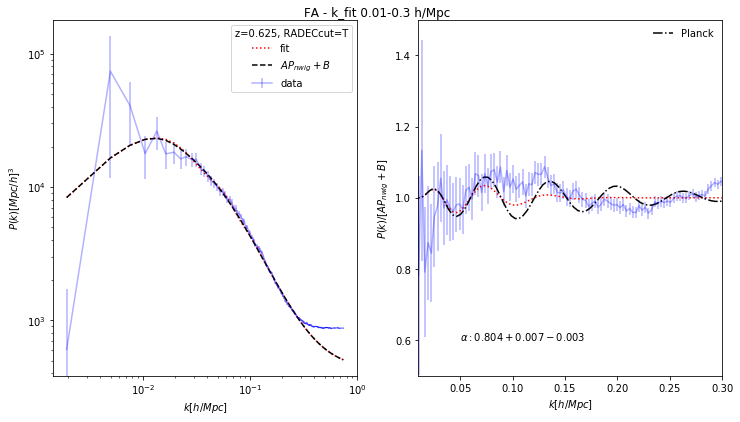

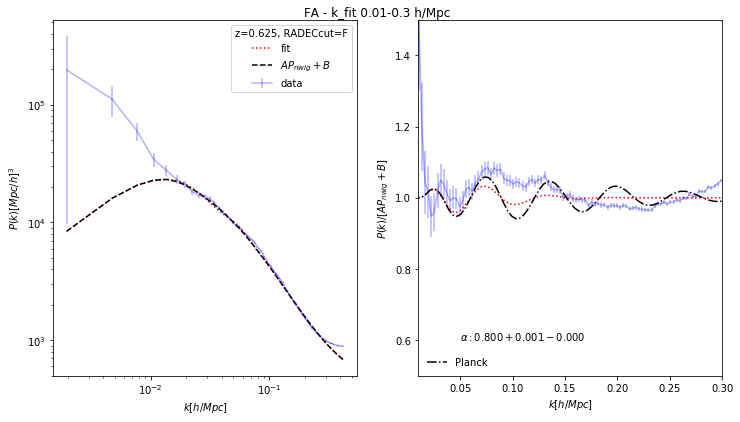

In [13]:
baofit = lambda z,c: './mcmc_fit_params_Pwig/kmin0.01_kmax0.3/fit_p0_z'+z+'RADECcut'+c+'_params1111.dat'
measur = lambda z,c: '../kp0kp2knmodes/surveyscaled-nmodes/kp0kp2knmodes_z'+z+'RADECcut'+c+'.dat'

def read_baofit(z,c, Baofit=baofit):
    b1 = Baofit(z,c)
    fb1 = open(b1, 'r')
    dic = {}
    for i,l in enumerate(fb1):
        if i>0:
            lines = l.split()
#             print(lines)
            dic[lines[0]] = [float(li) for li in lines[1:]]
#     print(dic)
    return dic
def plot_z(z, c, Baofit=baofit, Measur=measur, fit='fit', figadd=None): 
    nf = Nf(float(z), l=0)
    k,p, nmodes = np.loadtxt(Measur(z,c), usecols=(0,1,3), unpack=True)
    pe = p / np.sqrt(nmodes/2.)
    dic_fit = read_baofit(z,c,Baofit=Baofit)
    km, pm = model(k, alpha=dic_fit['#alpha:'][0], A=dic_fit['#A:'][0],\
                   B=dic_fit['#B:'][0], z_value=float(z), sigma2=dic_fit['#Sigma2_xy:'][0])
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
#     plt.rc('')
    fig.subplots_adjust(hspace=0.02, wspace=0.2, top=0.95)
    plt.suptitle('FA - k_fit 0.01-0.3 h/Mpc')
    # fit P_wig to P_measured to scale P_nowig to P_measured
    if fit == 'AB':
        axes[0].errorbar(k, p,yerr=pe, color='b',label='data', alpha=0.3)
        # model
        axes[0].plot(k, pm, 'r:', label='fit')
        # theory
        pnwig = lambda x: dic_fit['#A:'][0] * pnw_s(x) + dic_fit['#B:'][0]
        axes[0].plot(k, pnwig(km), 'k--', label=r'$AP_{nwig}+B$') # k should be shifted ie. km
        axes[0].set_yscale('log')
        axes[0].set_xscale('log')
        axes[0].set_ylabel(r'$P(k)[Mpc/h]^{3}$')
        axes[0].set_xlabel(r'$k[h/Mpc]$')

        axes[1].errorbar(k, p/pnwig(km), yerr=pe/pnwig(km), color='b', ls='-', alpha=0.3)
        axes[1].plot(km, pm/pnwig(km), 'r:')
        axes[1].plot(km, pwg_s(km)/pnw_s(km), 'k-.', label='Planck')
        axes[1].set_xlim(0.01, 0.3)
        axes[1].set_ylim(0.5, 1.5)
        axes[1].set_ylabel(r'$P(k)/[AP_{nwig}+B]$')
        axes[1].set_xlabel(r'$k[h/Mpc]$')
        a = dic_fit['#alpha:']
        print(a)
        axes[1].text(0.05, 0.6, r'$\alpha : {0[0]:.3f}+{0[1]:.3f}-{0[2]:.3f} $'.format(a))
        axes[1].legend(frameon=False)
        axes[0].legend(title='z={}, RADECcut={}'.format(z,c))        
for z in zstr[:1]:
    for c in cutstr[:]:
        plot_z(z, c, fit='AB')

alpha, A, B, sigma 0.801808 0.9315319 14.4707778 180.9229727
[0.801808, 0.0035127, 0.0013915]
alpha, A, B, sigma 0.8002441 0.9433303 5.9801319 196.296425
[0.8002441, 0.0004441, 0.0001875]


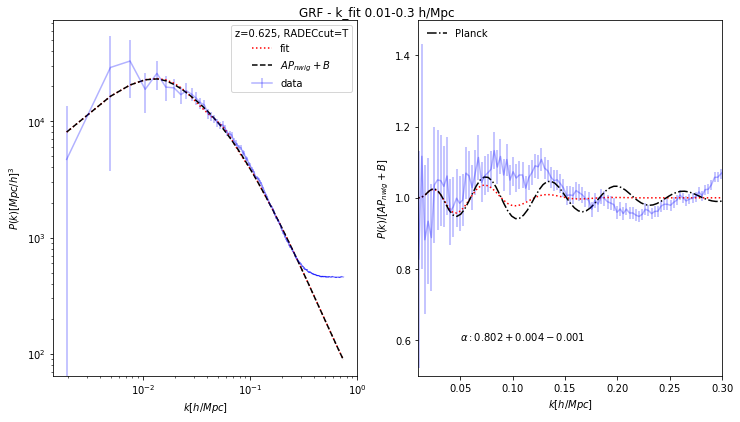

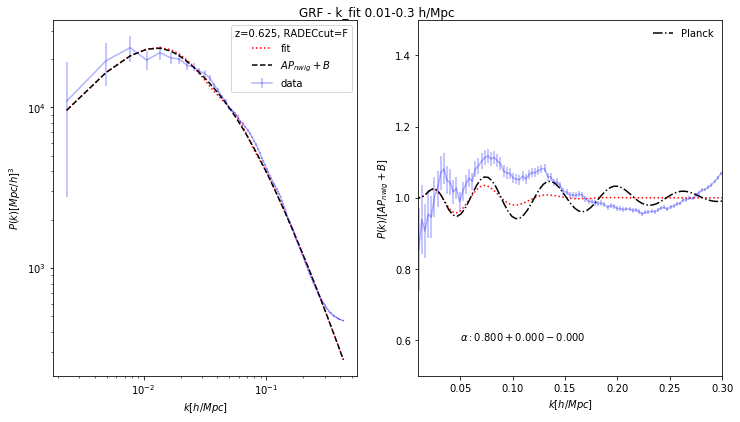

In [15]:
baofit = lambda z,c: './mcmc_fit_params_Pwigtrue/kmin0.01_kmax0.3/fit_p0_z'+z+'RADECcut'+c+'_params1111.dat'
measur = lambda z,c: '../kp0kp2knmodes/surveyscaled-nmodes/truekp0kp2knmodes_z'+z+'RADECcut'+c+'.dat'

def read_baofit(z,c, Baofit=baofit):
    b1 = Baofit(z,c)
    fb1 = open(b1, 'r')
    dic = {}
    for i,l in enumerate(fb1):
        if i>0:
            lines = l.split()
#             print(lines)
            dic[lines[0]] = [float(li) for li in lines[1:]]
#     print(dic)
    return dic
def plot_z(z, c, Baofit=baofit, Measur=measur, fit='fit', figadd=None): 
    nf = Nf(float(z), l=0)
    k,p, nmodes = np.loadtxt(Measur(z,c), usecols=(0,1,3), unpack=True)
    pe = p / np.sqrt(nmodes/2.)
    dic_fit = read_baofit(z,c,Baofit=Baofit)
    km, pm = model(k, alpha=dic_fit['#alpha:'][0], A=dic_fit['#A:'][0],\
                   B=dic_fit['#B:'][0], z_value=float(z), sigma2=dic_fit['#Sigma2_xy:'][0])
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
#     plt.rc('')
    fig.subplots_adjust(hspace=0.02, wspace=0.2, top=0.95)
    plt.suptitle('GRF - k_fit 0.01-0.3 h/Mpc')
    # fit P_wig to P_measured to scale P_nowig to P_measured
    if fit == 'AB':
        axes[0].errorbar(k, p,yerr=pe, color='b',label='data', alpha=0.3)
        # model
        axes[0].plot(k, pm, 'r:', label='fit')
        # theory
        pnwig = lambda x: dic_fit['#A:'][0] * pnw_s(x) + dic_fit['#B:'][0]
        axes[0].plot(k, pnwig(km), 'k--', label=r'$AP_{nwig}+B$') # k should be shifted ie. km
        axes[0].set_yscale('log')
        axes[0].set_xscale('log')
        axes[0].set_ylabel(r'$P(k)[Mpc/h]^{3}$')
        axes[0].set_xlabel(r'$k[h/Mpc]$')

        axes[1].errorbar(k, p/pnwig(km), yerr=pe/pnwig(km), color='b', ls='-', alpha=0.3)
        axes[1].plot(km, pm/pnwig(km), 'r:')
        axes[1].plot(km, pwg_s(km)/pnw_s(km), 'k-.', label='Planck')
        axes[1].set_xlim(0.01, 0.3)
        axes[1].set_ylim(0.5, 1.5)
        axes[1].set_ylabel(r'$P(k)/[AP_{nwig}+B]$')
        axes[1].set_xlabel(r'$k[h/Mpc]$')
        a = dic_fit['#alpha:']
        print(a)
        axes[1].text(0.05, 0.6, r'$\alpha : {0[0]:.3f}+{0[1]:.3f}-{0[2]:.3f} $'.format(a))
        axes[1].legend(frameon=False)
        axes[0].legend(title='z={}, RADECcut={}'.format(z,c))        
for z in zstr[:1]:
    for c in cutstr[:]:
        plot_z(z, c, fit='AB')

In [ ]:
res = ['Irene Adler', 35,  24.798]
print('{0[0]:10s} {0[1]:5d} {0[2]:.2f}'.format(res))
print('{:{}s} {:{}d} {:{}f}'.format(res[0], 10, res[1], 5, res[2], .2))

In [88]:
print('{0[0]:{1}s} {0[1]:{2}d} {0[2]:{3}f}'.format(res, 10, 5, .2))

Irene Adler    35 24.80
